In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import re
import scipy.io as scio
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
%config InlineBackend.figure_format = 'retina'

In [126]:
path_to_mrm = 'mrm_data/'
path_to_aepw3 = '../pazy-aepw3-results/'

In [106]:
file_names = {}
file_names['0'] = {'mrm': 'AE results from MRM of UM beam model wing 1 WO skin',
                  'results': 'mrm_umbeam_wo_skin'}
file_names['1'] = {'mrm': 'AE results from MRM of UM beam model wing 1 W skin',
                  'results': 'mrm_umbeam_w_skin'}
file_names['2'] = {'mrm': 'AE results from MRM of Nastran model wing 1',
                  'results': 'mrm_nastran'}
file_names['3'] = {'mrm': 'AE results from MRM of Nastran model wing 1 with weight',
                  'results': 'mrm_nastran_te1'}

In [385]:
mat = scio.loadmat(path_to_mrm + file_names['0']['mrm'] + '.mat')

In [386]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Norberto_AoA_Data', 'Norberto_Static_AE_Data', 'Norberto_Vel_Data', 'Norberto_deformations_at_vf_data', 'Norberto_frequency_Data', 'Norberto_frequency_Data_new', 'Norberto_nonmached_flutter_Data', 'Norberto_nonmached_flutter_Data_new', 'Norberto_vf_mached_Data'])

In [387]:
for k, v in mat.items():
    print('\n\n---------------------')
    print('Key:', k)
    try:
        print('Shape: ', v.shape)
        print(v)
    except AttributeError:
        pass



---------------------
Key: __header__


---------------------
Key: __version__


---------------------
Key: __globals__


---------------------
Key: Norberto_AoA_Data
Shape:  (2, 1)
[[0.08726646]
 [0.12217305]]


---------------------
Key: Norberto_Static_AE_Data
Shape:  (16, 2)
[[0.         0.        ]
 [0.00211295 0.00295811]
 [0.00848284 0.01187466]
 [0.01952135 0.02730112]
 [0.03576279 0.04994153]
 [0.05784692 0.0800956 ]
 [0.0863445  0.11796276]
 [0.12167421 0.16244921]
 [0.16332698 0.21108414]
 [0.2096589  0.25999137]
 [0.25753869 0.30556188]
 [0.30343046 0.34520699]
 [0.34426235 0.37779084]
 [0.37843253 0.40336853]
 [0.40557532 0.42328219]
 [0.42612051 0.43802864]]


---------------------
Key: Norberto_Vel_Data
Shape:  (16, 1)
[[ 0]
 [ 6]
 [12]
 [18]
 [24]
 [30]
 [36]
 [42]
 [48]
 [54]
 [60]
 [66]
 [72]
 [78]
 [84]
 [90]]


---------------------
Key: Norberto_deformations_at_vf_data
Shape:  (1, 3)
[[0.         0.19354008 0.18516904]]


---------------------
Key: Norberto_frequ

In [99]:
def frequency(mat, i_aoa):
    vels = []
    freqs = []
    for i in range(4):
#         plt.scatter(mat['Norberto_Vel_Data'][:, 0], mat['Norberto_frequency_Data'][:, i, 0])
        vels.append(mat['Norberto_Vel_Data'][:, 0].astype(float))
        freqs.append(mat['Norberto_frequency_Data'][:, i, i_aoa])
    vels = np.concatenate(vels)
    freqs = np.concatenate(freqs)
    order = np.argsort(vels)
    vels = np.array([vels[i] for i in order])
    freqs = np.array([freqs[i] for i in order])
#     print(vels)
#     print(freqs)
#     plt.scatter(vels, freqs)
    return vels, freqs

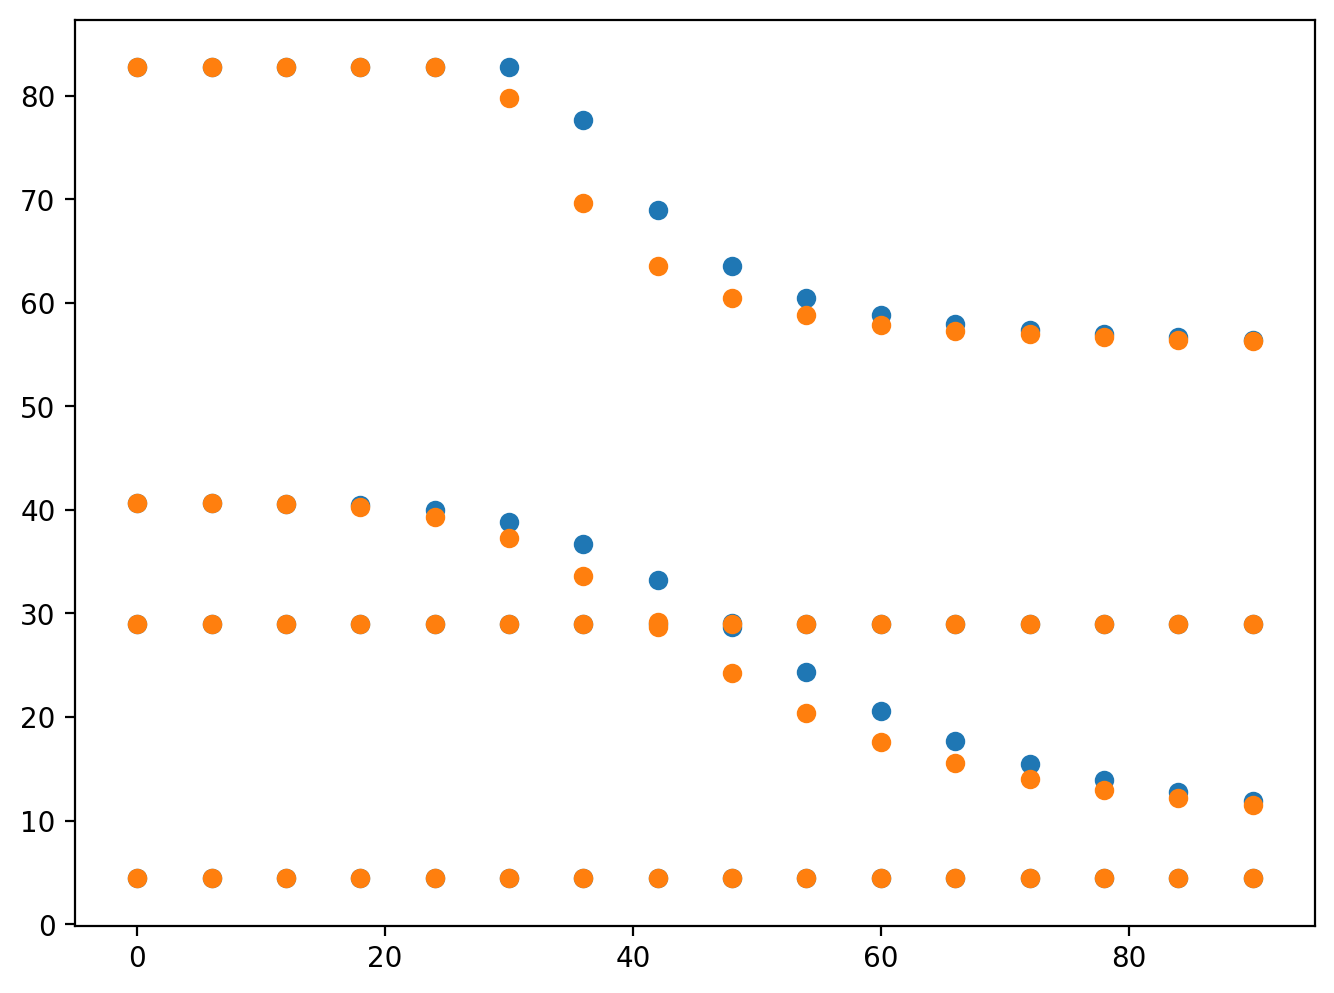

In [102]:
plt.scatter(*frequency(mat, 0))
plt.scatter(*frequency(mat, 1))

In [305]:
def static_deflection_speed(mat, i_aoa):
    vels = mat['Norberto_Vel_Data'][:, 0].astype(float)
    deflection = mat['Norberto_Static_AE_Data'][:, i_aoa]

    return vels, deflection

In [395]:
def matched_flutter(mat, i_aoa):
    if i_aoa is not None:
        deflection = mat['Norberto_Static_AE_Data'][:, i_aoa]
        vels = mat['Norberto_Vel_Data'][:, 0].astype(float)
        flutter_speed = mat['Norberto_vf_mached_Data'][0, i_aoa+1]
        deflection_at_vf = np.interp(flutter_speed, vels, deflection)
    
        return flutter_speed, deflection_at_vf
    else:
        return mat['Norberto_vf_mached_Data'][0, 0], 0

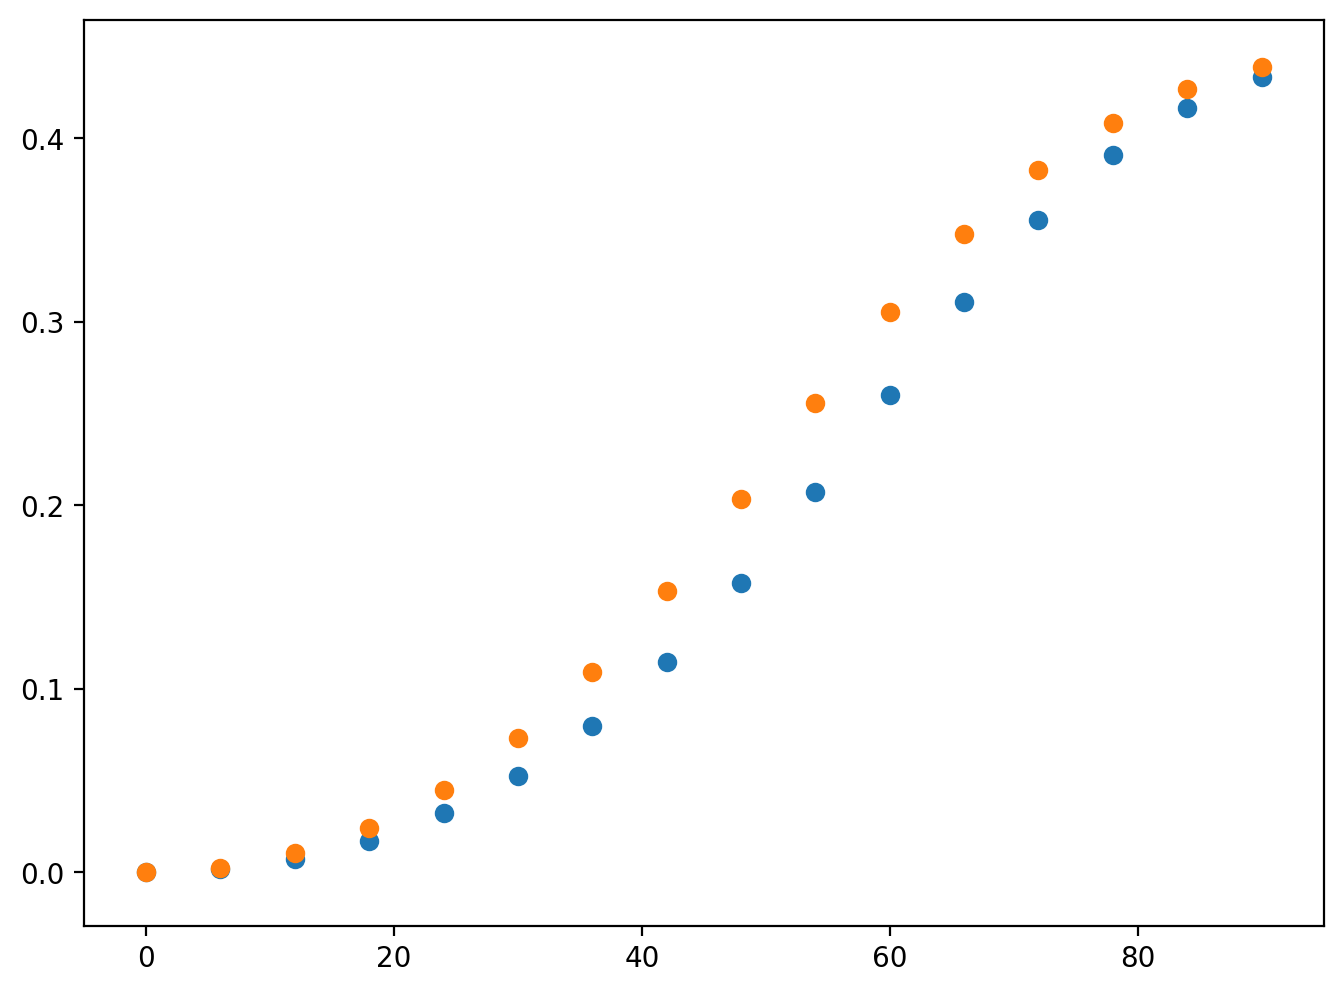

In [306]:
plt.scatter(*static_deflection_speed(mat, 0))
plt.scatter(*static_deflection_speed(mat, 1))

# Save in AEPW3

In [396]:
import os
for i in range(len(file_names)):
    
    if not os.path.isdir(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results']):
        os.makedirs(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'])
    
    mat = scio.loadmat(path_to_mrm + '/' + file_names[str(i)]['mrm'] + '.mat')
    aoa = [5., 7.]
    for i_aoa in range(2):
        # VELOCITY FREQUENCY
        vels, freq = frequency(mat, i_aoa)
        np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'] + '/velocity_frequency_alpha{:04g}.txt'.format(aoa[i_aoa] * 100),
                  np.column_stack((vels, freq)))
        
        # STATIC DEFLECTION SPEED
        vels, deflection = static_deflection_speed(mat, i_aoa)
        np.savetxt(path_to_aepw3 + '/03_StaticAeroelastic/' + file_names[str(i)]['results'] + '_alpha{:04g}.txt'.format(aoa[i_aoa] * 100),
                  np.column_stack((vels, deflection)))
        
        # DEFORMED FLUTTER
        vf, deflection = matched_flutter(mat, i_aoa)
        np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'] + '/flutter_speeds_alpha{:04g}.txt'.format(aoa[i_aoa] * 100),
                  np.column_stack((vf, deflection)))
        
    # STRAIGHT WING FLUTTER
    vf, deflection = matched_flutter(mat, None)
    np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'] + '/flutter_speeds_alpha{:04g}.txt'.format(0.),
              np.column_stack((vf, deflection)))

In [373]:
cs = []
thrust = []
with open('/home/ng213/2TB/HH_HALE/09_MPC_Simulation/output/simple_HALE_mpc_mass_centredrop/input_history.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        ll = line.split(',')
        try:
            cs.append(float(ll[0]))
            thrust.append(float(ll[1]))
        except ValueError:
            pass
        
cs = np.array(cs)
thrust = np.array(thrust)

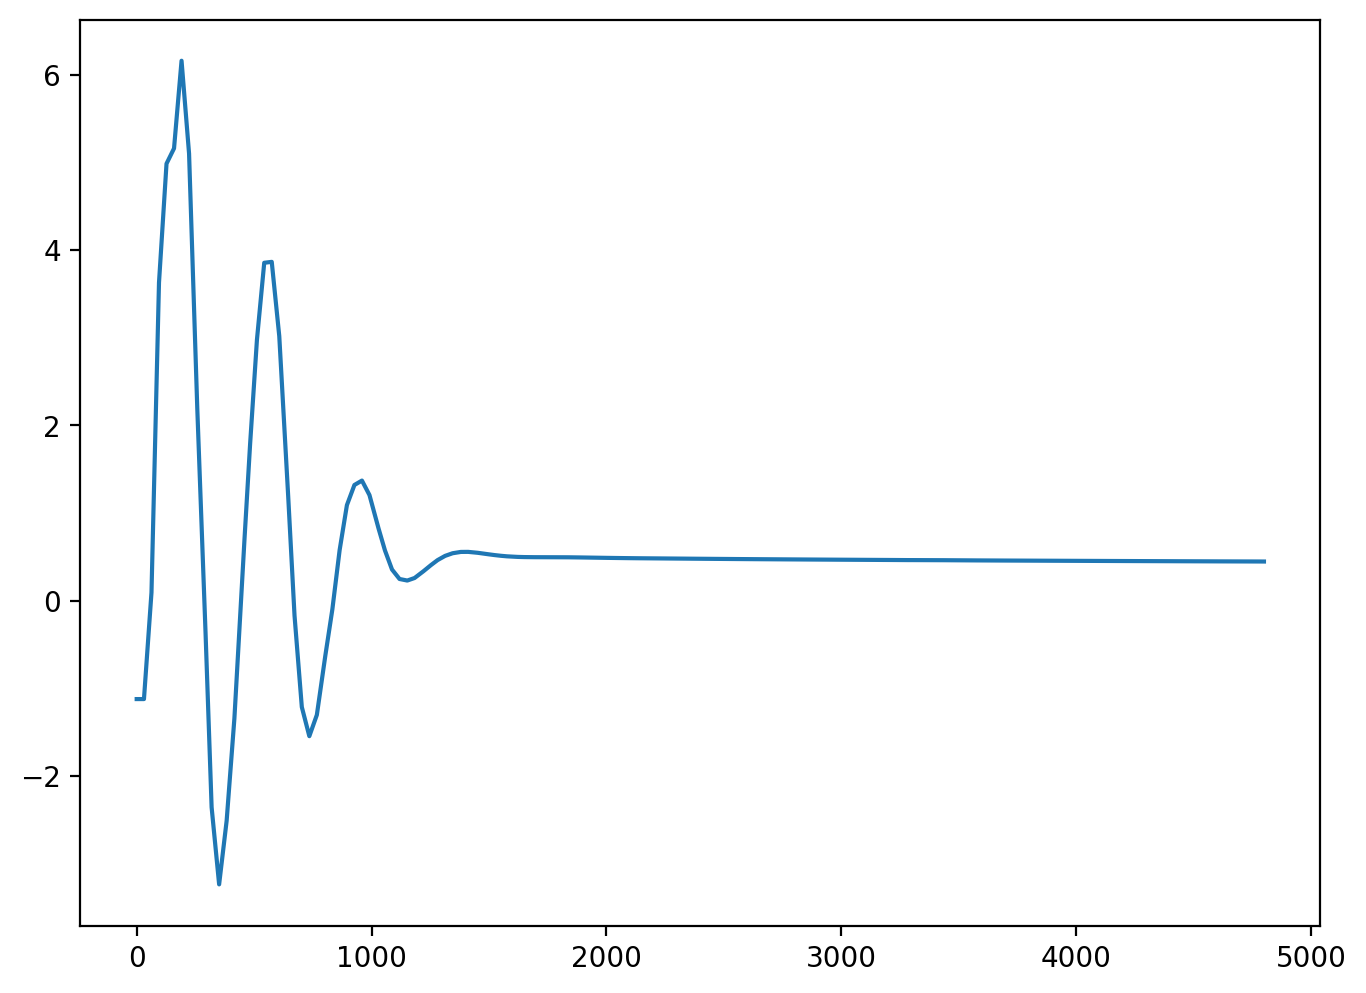

In [374]:
plt.plot(cs * 180 / np.pi)

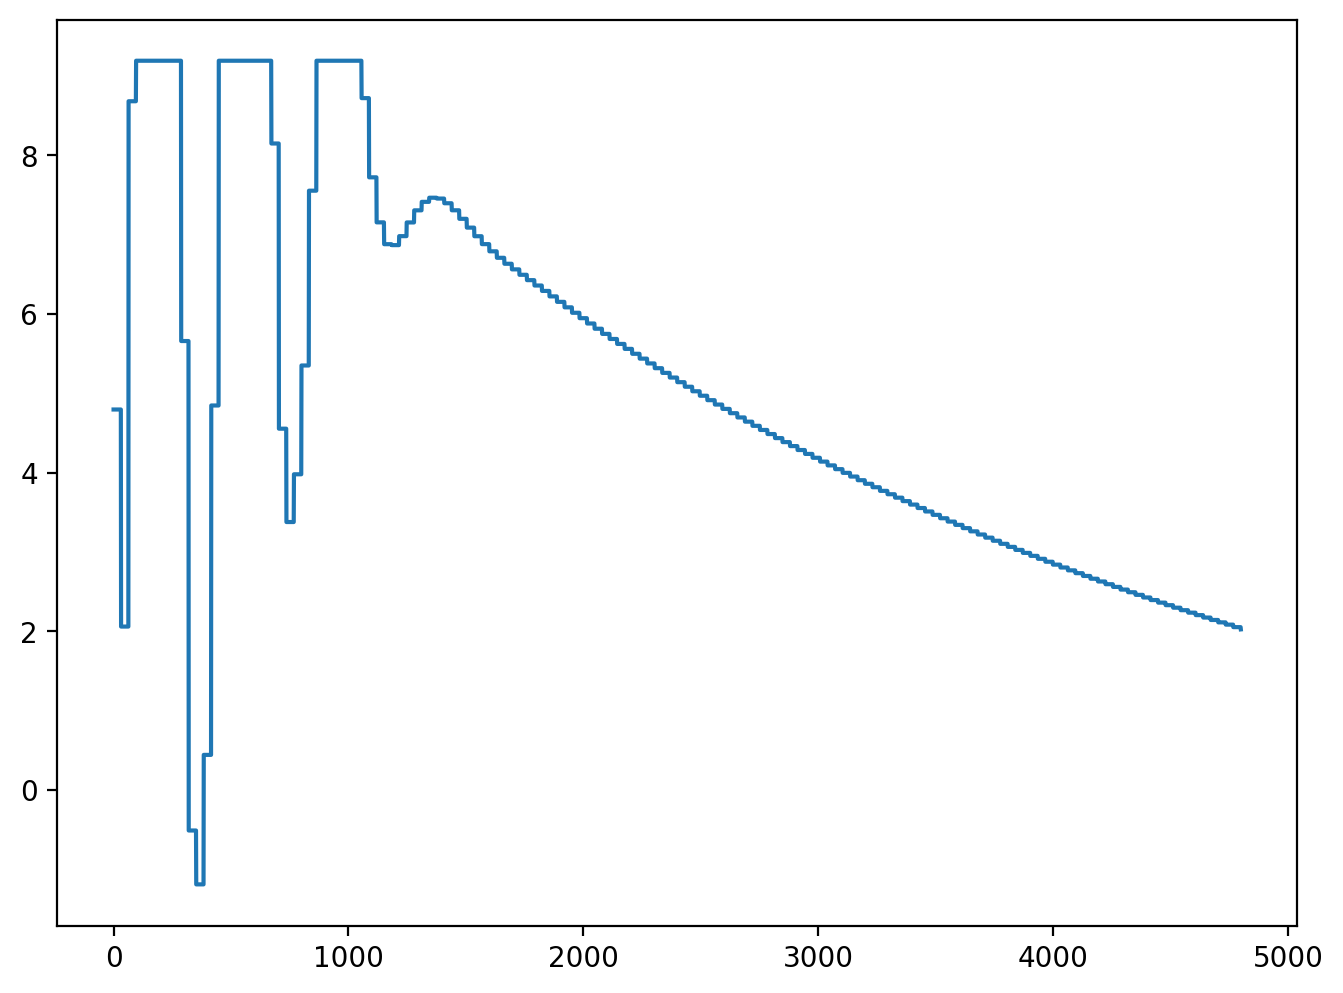

In [375]:
plt.plot(thrust)

In [376]:
ol = np.loadtxt('/home/ng213/2TB/HH_HALE/03_PayloadDrop/output/simple_HALE_mass_centredrop/WriteVariablesTime/FoR_00_for_pos.dat')

In [377]:
cl = np.loadtxt('/home/ng213/2TB/HH_HALE/09_MPC_Simulation/output/simple_HALE_mpc_mass_centredrop/WriteVariablesTime/FoR_00_for_pos.dat')

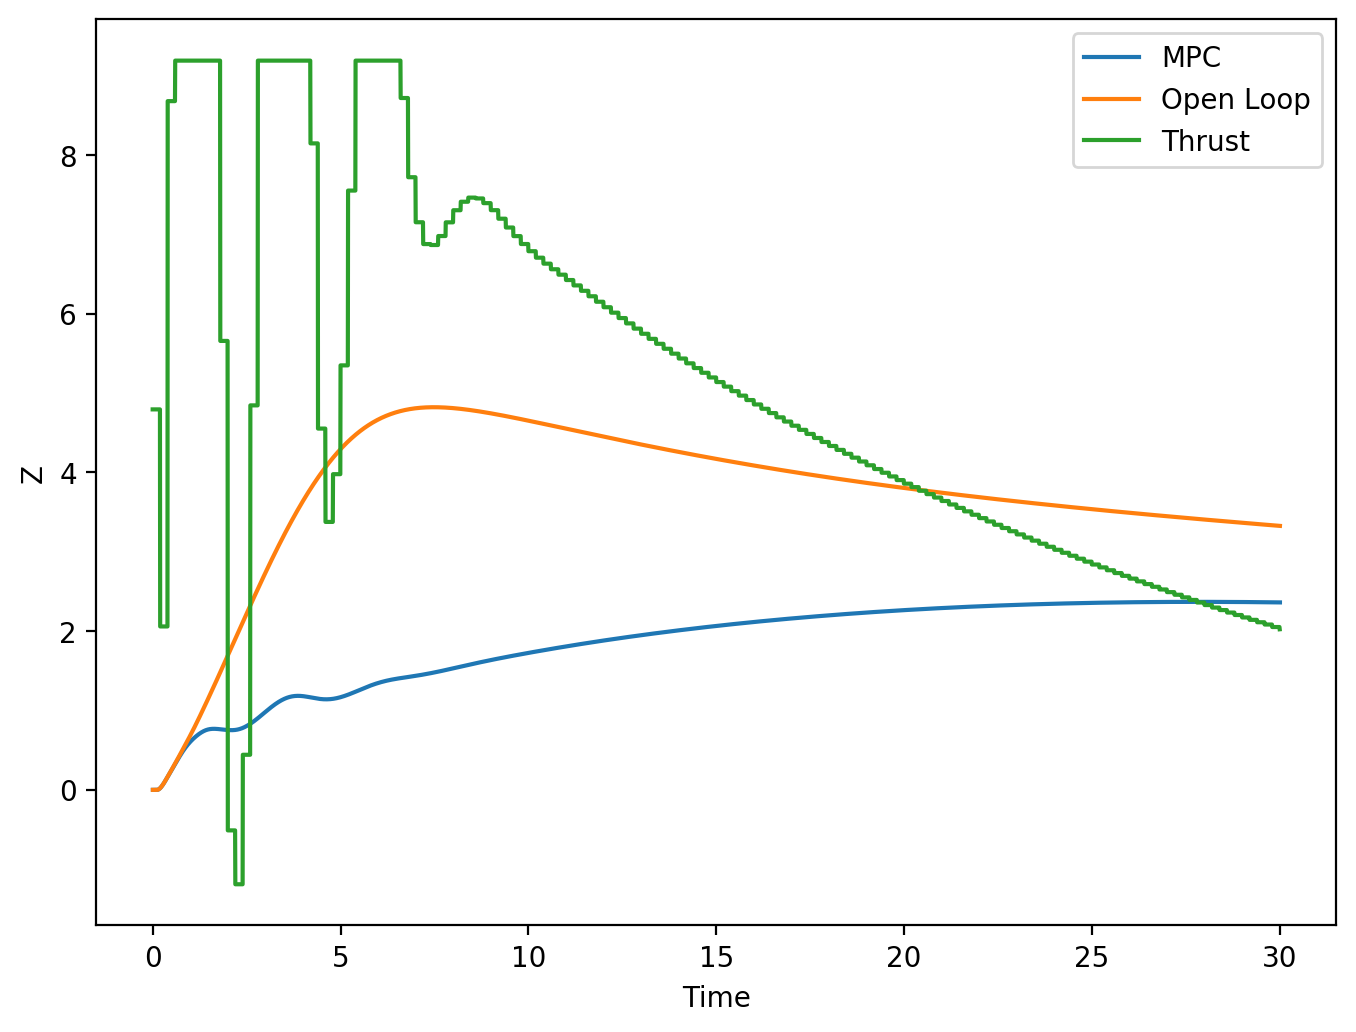

In [378]:
plt.plot(cl[:, 0] / 160, cl[:, 3], label='MPC')
plt.plot(ol[:, 0] / 160, ol[:ol.shape[0], 3], label='Open Loop')

plt.plot(np.arange(len(thrust)) / 160, thrust, label='Thrust')
plt.xlabel('Time')
plt.ylabel('Z')
plt.legend()
# plt.xlim(0, 6)

In [379]:
vel_cl = np.loadtxt('/home/ng213/2TB/HH_HALE/09_MPC_Simulation/output/simple_HALE_mpc_mass_centredrop/WriteVariablesTime/FoR_00_for_vel.dat')

In [380]:
vel_ol = np.loadtxt('/home/ng213/2TB/HH_HALE/03_PayloadDrop/output/simple_HALE_mass_centredrop/WriteVariablesTime/FoR_00_for_vel.dat')

In [381]:
aoa_cl = np.arctan(vel_cl[:, 3]/vel_cl[:, 1])
aoa_ol = np.arctan(vel_ol[:, 3]/vel_ol[:, 1])

Text(0, 0.5, 'Angle of attack, deg')

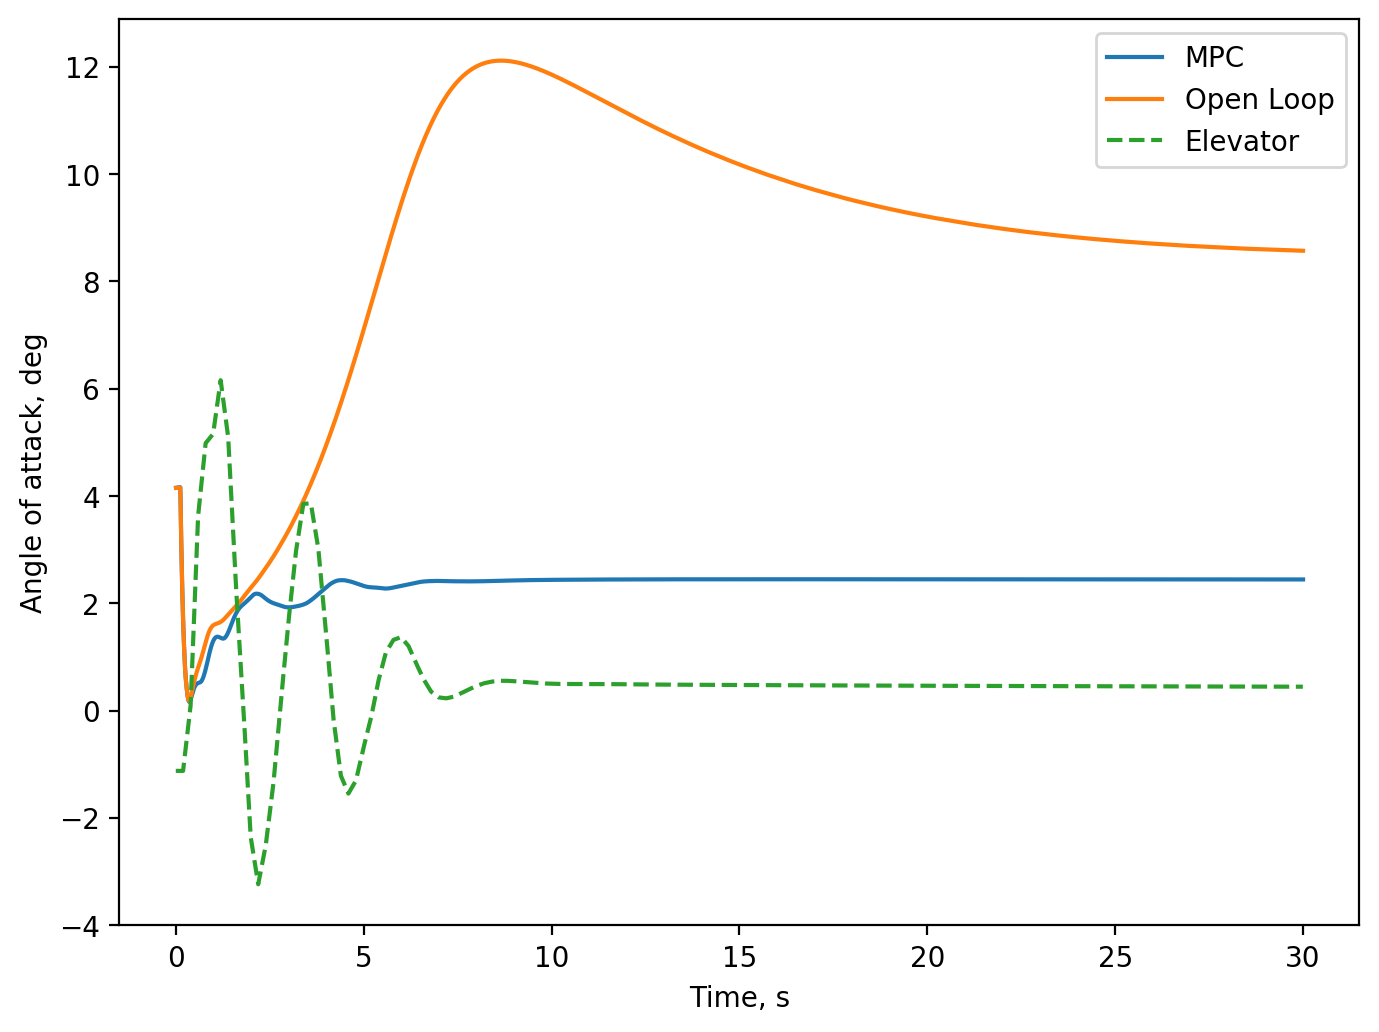

In [382]:
plt.plot(cl[:, 0] / 160, aoa_cl * 180 / np.pi, label='MPC')
plt.plot(ol[:, 0] / 160, aoa_ol * 180 / np.pi, label='Open Loop')
plt.plot(np.arange(len(cs)) / 160, cs * 180 / np.pi, ls='--', label='Elevator')

# plt.xlim(0, 6)
plt.legend()
plt.xlabel('Time, s')
plt.ylabel('Angle of attack, deg')

Text(0, 0.5, 'True Airspeed, m/s')

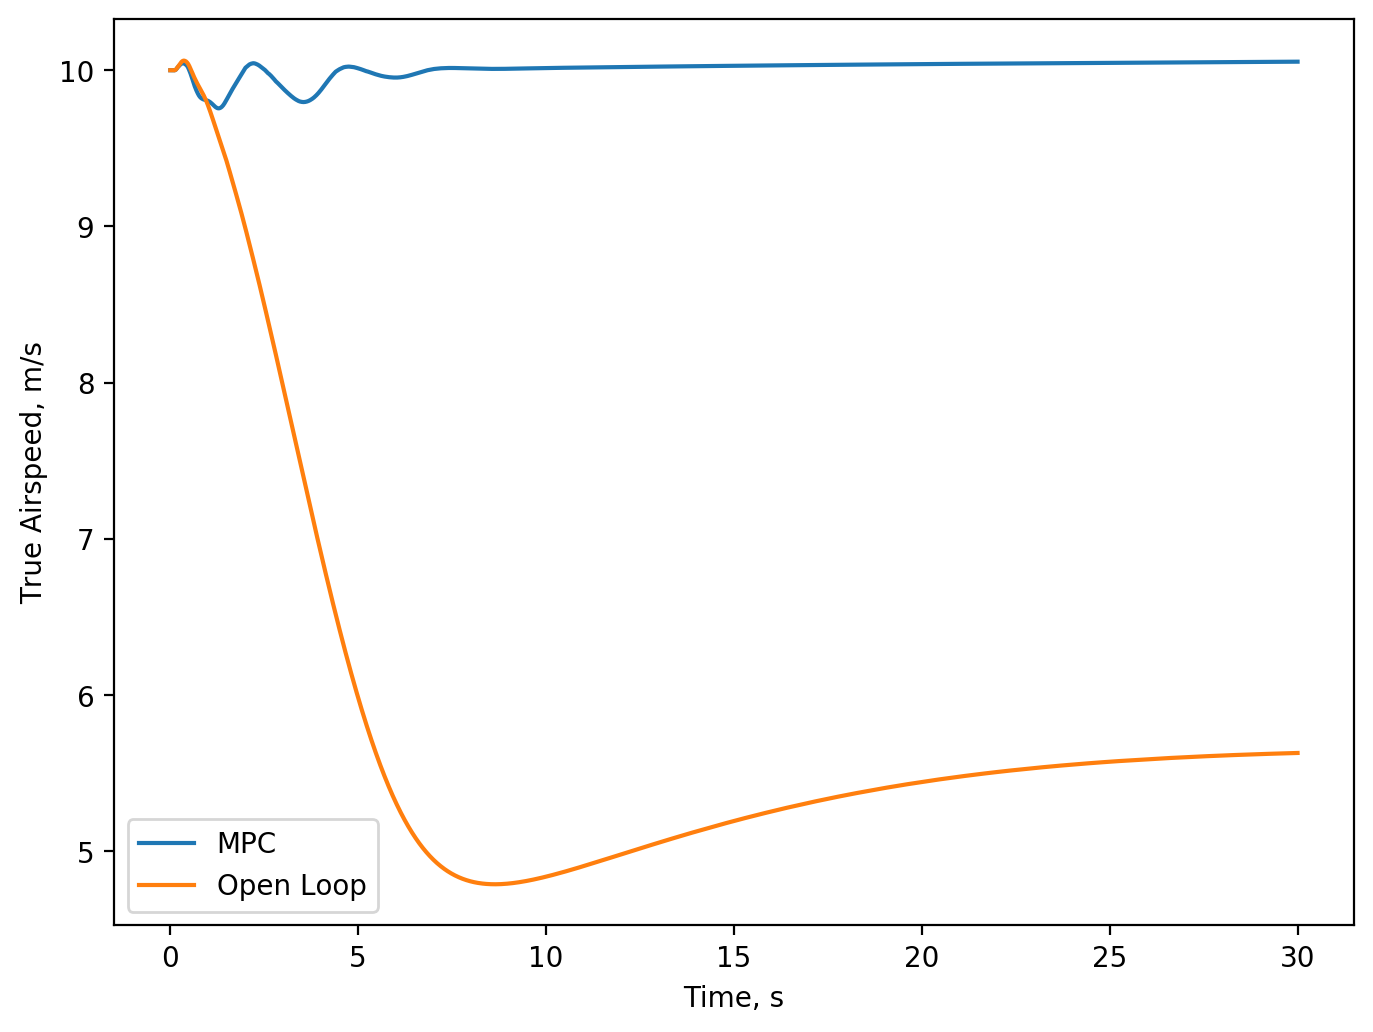

In [383]:
plt.plot(cl[:, 0] / 160, np.linalg.norm(vel_cl[:, 1:], axis=1), label='MPC')
plt.plot(ol[:, 0] / 160, np.linalg.norm(vel_ol[:, 1:], axis=1), label='Open Loop')

# plt.xlim(0, 6)
plt.legend()
plt.xlabel('Time, s')
plt.ylabel('True Airspeed, m/s')